# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
%%info

In [2]:
sc.list_packages()
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("scipy==1.5.4")
sc.install_pypi_package("seaborn==0.10.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1638450874044_0004,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.1    
boto                       2.49.0   
click                      7.1.2    
jmespath                   0.10.0   
joblib                     0.16.0   
lxml                       4.5.2    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pip                        9.0.1    
py-dateutil                2.2      
python37-sagemaker-pyspark 1.4.0    
pytz                       2020.1   
PyYAML                     5.3.1    
regex                      2020.7.14
setuptools                 28.8.0   
six                        1.13.0   
soupsieve                  1.9.5    
tqdm                       4.48.2   
wheel                      0.29.0   
windmill                   1.6      

  Using cached https://files.pythonhosted.org/packages/4a/6a/94b219b8ea0f2d580169e85ed1edc0163743f55aaeca8a44c2

## Importing

Now, import the installed packages from the previous block below.

In [3]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [4]:
JSON_PATH = "s3://sta9760yuxisong/yelp_academic_dataset_business.json"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
df_business = spark.read.json(JSON_PATH)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
print('Data frame type: ' + str(type(df_business)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>

## Overview of Data

Display the number of rows and columns in our dataset.

In [7]:
print(f'Total Columns: {len(df_business.dtypes)}')
print(f'Total Rows: {df_business.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 160,585

Display the DataFrame schema below.

In [8]:
df_business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [9]:
cols = ["business_id","name","city","state","categories"]
df_business.select(*cols).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------+-----+--------------------+
|         business_id|                name|       city|state|          categories|
+--------------------+--------------------+-----------+-----+--------------------+
|6iYb2HFDywm3zjuRg...| Oskar Blues Taproom|    Boulder|   CO|Gastropubs, Food,...|
|tCbdrRPZA0oiIYSmH...|Flying Elephants ...|   Portland|   OR|Salad, Soup, Sand...|
|bvN78flM8NLprQ1a1...|      The Reclaimory|   Portland|   OR|Antiques, Fashion...|
|oaepsyvc0J17qwi8c...|         Great Clips|Orange City|   FL|Beauty & Spas, Ha...|
|PE9uqAjdw0E4-8mjG...|   Crossfit Terminus|    Atlanta|   GA|Gyms, Active Life...|
+--------------------+--------------------+-----------+-----+--------------------+
only showing top 5 rows

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [10]:
df_business.select('business_id').where(df_business.categories == "Active Life").count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

5

In [11]:
#split
from pyspark.sql.functions import explode, split

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
categories_ratings = df_business.withColumn("category", explode(split('categories', ", ")))
categories_ratings.select('business_id', 'category')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[business_id: string, category: string]

In [13]:
#most popular top 20 categories
from pyspark.sql.functions import col, mean

most_pop_categories = categories_ratings \
    .select("category", "stars") \
    .withColumn("stars", col("stars").cast("Integer")) \
    .groupBy("category") \
    .agg(mean('stars').alias("stars")) \
    .sort(col("stars").desc())
most_pop_categories.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+
|            category|            stars|
+--------------------+-----------------+
|          Club Crawl|              5.0|
|         LAN Centers|              5.0|
|      Karaoke Rental|              5.0|
|           Feng Shui|              5.0|
|     Speech Training|              5.0|
|         Calligraphy|              5.0|
|         Free Diving|              5.0|
|       Carpet Dyeing|              5.0|
|    Snuggle Services|              5.0|
|          Bocce Ball|              5.0|
|      Circus Schools|              5.0|
|  Mobile Home Repair|              5.0|
|              Drones|              5.0|
|              Mohels|              5.0|
|    Fire Departments|              5.0|
|Placenta Encapsul...|4.857142857142857|
| Boudoir Photography|4.823529411764706|
|         Makerspaces|              4.8|
|     Luggage Storage|              4.8|
|         Caricatures|              4.8|
+--------------------+-----------------+
only showing top

Display the first 5 rows of your association table below.

In [14]:
# Display the first 5 rows
categories_ratings = df_business.withColumn("category", explode(split('categories', ", ")))
categories_ratings.select('business_id', 'category').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+
|         business_id|    category|
+--------------------+------------+
|6iYb2HFDywm3zjuRg...|  Gastropubs|
|6iYb2HFDywm3zjuRg...|        Food|
|6iYb2HFDywm3zjuRg...|Beer Gardens|
|6iYb2HFDywm3zjuRg...| Restaurants|
|6iYb2HFDywm3zjuRg...|        Bars|
+--------------------+------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [15]:
total_unique_categories = categories_ratings.select('business_id', "category")
total_unique_categories.select("category").distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1330

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [16]:
categories_grouped = categories_ratings.groupby('category')
categories_grouped.count().show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|      Dermatologists|  351|
|      Paddleboarding|   67|
|        Aerial Tours|    8|
|         Hobby Shops|  610|
|          Bubble Tea|  779|
|             Embassy|    9|
|             Tanning|  701|
|            Handyman|  507|
|      Aerial Fitness|   13|
|             Falafel|  141|
|        Summer Camps|  308|
|       Outlet Stores|  184|
|     Clothing Rental|   37|
|      Sporting Goods| 1864|
|     Cooking Schools|  114|
|  College Counseling|   20|
|  Lactation Services|   47|
|Ski & Snowboard S...|   55|
|             Museums|  336|
|              Doulas|   52|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [17]:
barchart_df = categories_ratings.groupby("category").count().orderBy('count', ascending=False).limit(20).toPandas()
barchart_df = barchart_df.set_index('category','count')
barchart_df = barchart_df.sort_values(by='count', ascending=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
plt.figure(figsize =(18,9))
plt.figure(figsize =(18,9))
barchart_df.plot.barh(figsize=(18,9))
#pdf.sort_values("count", inplace=False)
plt.title("Top Categories by Business", fontsize = 16, fontweight = "bold")
plt.ylabel("Category", fontsize = 13 )
plt.xlabel("Count", fontsize = 13 )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 0, 'Count')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

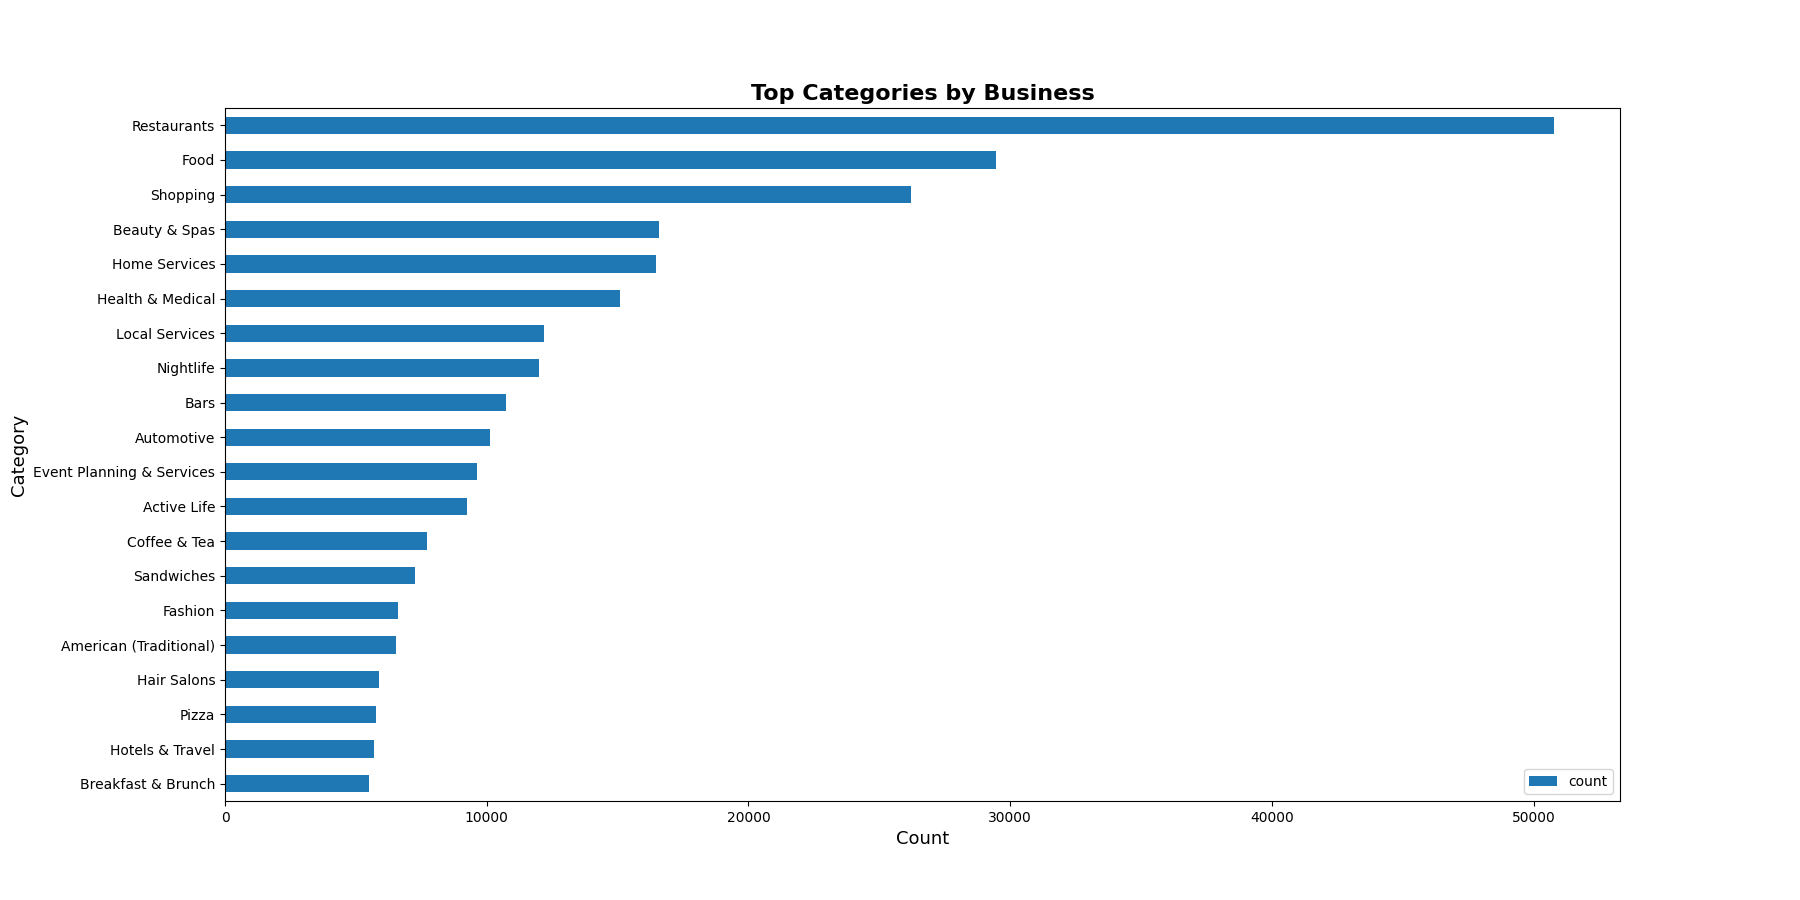

In [19]:
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [20]:
JSON_PATH2 = "s3://sta9760yuxisong/yelp_academic_dataset_review.json"
df_review = spark.read.json(JSON_PATH2)
print('Data frame type: ' + str(type(df_review)))
df_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [21]:
cols1 = ["business_id","stars"]
df_review.select(*cols1).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|buF9druCkbuXLX526...|  4.0|
|RA4V8pr014UyUbDvI...|  4.0|
|_sS2LBIGNT5NQb6PD...|  5.0|
|0AzLzHfOJgL7ROwhd...|  2.0|
|8zehGz9jnxPqXtOc7...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [22]:
from pyspark.sql.functions import avg
df_new = df_review.groupBy("business_id").avg("stars")
df_new.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+
|         business_id|       avg(stars)|
+--------------------+-----------------+
|yHtuNAlYKtRZniO8O...|4.714285714285714|
|R0IJhEI-zSJpYT1YN...|3.606060606060606|
|uEUweopM30lHcVxjO...|              3.0|
|L3WCfeVozu5etMhz4...|              4.2|
|XzXcpPCb8Y5huklEN...|4.666666666666667|
+--------------------+-----------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [23]:
df1 = df_new.select('business_id','avg(stars)')
df2 = df_business.select('business_id','stars','name','city','state')
joined_df = df1.join(df2, df1.business_id == df2.business_id)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [24]:
# Display 5 first rows
joined_df = joined_df.select('avg(stars)','stars','name','city','state')
joined_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+----------+-----+
|        avg(stars)|stars|                name|      city|state|
+------------------+-----+--------------------+----------+-----+
|               5.0|  5.0|    CheraBella Salon|   Peabody|   MA|
|             3.875|  4.0|Mezcal Cantina & ...|  Columbus|   OH|
|3.8666666666666667|  4.0|    Red Table Coffee|    Austin|   TX|
|               5.0|  5.0|          WonderWell|    Austin|   TX|
|             3.375|  3.5|         Avalon Oaks|Wilmington|   MA|
+------------------+-----+--------------------+----------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [25]:
df_skew = joined_df.select('avg(stars)','stars').toPandas()
df_skew["skew"] = (df_skew['avg(stars)'] - df_skew['stars']) / df_skew['stars']
df_skew

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        avg(stars)  stars      skew
0         4.714286    4.5  0.047619
1         3.606061    3.5  0.030303
2         3.000000    3.0  0.000000
3         4.200000    4.0  0.050000
4         4.666667    4.5  0.037037
...            ...    ...       ...
160580    4.400000    4.5 -0.022222
160581    3.755102    3.5  0.072886
160582    4.800000    5.0 -0.040000
160583    3.782609    4.0 -0.054348
160584    2.692308    3.0 -0.102564

[160585 rows x 3 columns]

And finally, graph it!

In [26]:
import seaborn as sns
plt.figure(figsize=(12,4))
sns.distplot(df_skew["skew"])
sns.despine(left = True)
plt.title('Skewness - Reviews', size = 16)
plt.axis((-0.6, 1.30, 0, 11))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(-0.6, 1.3, 0.0, 11.0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

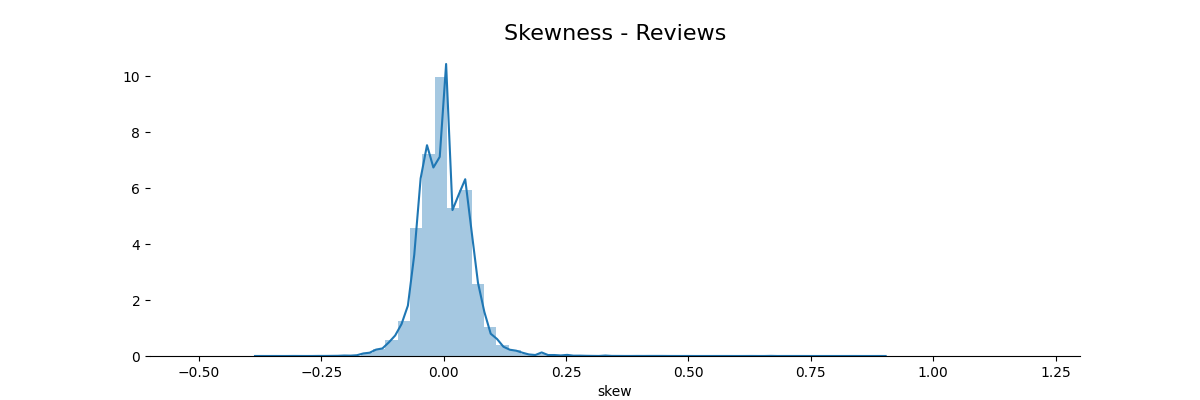

In [27]:
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

In [28]:
# Calculate skewness
a = df_skew['skew'].median() #median
b = df_skew['skew'].mean() #mean
c = df_skew['skew'].std() #standard deviation
d = (3 * (b-a) / c) #skewness

print('MEDIAN:', a)
print('MEAM:', b)
print('STD_DEV:', c)
print('SKEWNESS:', d)

# Implications:
# According to the formula, I got skewness of 0.06675734810456932. 
# Thus, Yelp reviews is positive
# It means reviewers who left a written response were more satisfied than normal

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

MEDIAN: 0.0
MEAM: 0.0011443037144630325
STD_DEV: 0.05142371949844016
SKEWNESS: 0.0667573481045693

# Should the Elite be Trusted? (Or, some other analysis of your choice)

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

In [29]:
JSON_PATH3 = "s3://sta9760yuxisong/yelp_academic_dataset_user.json"
df_user = spark.read.json(JSON_PATH3)
print('Data frame type: ' + str(type(df_review)))
df_user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [30]:
df_user.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['average_stars', 'compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool', 'elite', 'fans', 'friends', 'funny', 'name', 'review_count', 'useful', 'user_id', 'yelping_since']

In [31]:
#Select columns
cols2 = ["user_id","elite","average_stars"]
df_user.select(*cols2).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------------+
|             user_id|               elite|average_stars|
+--------------------+--------------------+-------------+
|q_QQ5kBBwlCcbL1s4...|2006,2007,2008,20...|         3.85|
|dIIKEfOgo0KqUfGQv...|2007,2008,2009,20...|         4.09|
|D6ErcUnFALnCQN4b1...|           2010,2011|         3.76|
|JnPIjvC0cmooNDfsa...|2009,2010,2011,20...|         3.77|
|37Hc8hr3cw0iHLoPz...|      2009,2010,2011|         3.72|
+--------------------+--------------------+-------------+
only showing top 5 rows

In [32]:
elite = df_user.filter(df_user['elite'] != '').select('user_id', 'elite', 'average_stars')
review = df_review.select('user_id', 'stars', 'business_id')
elite_user_review = elite.join(review, elite.user_id == review.user_id).drop(review['user_id'])
elite_user_review.show(5)

df_new.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------------+-----+--------------------+
|             user_id|               elite|average_stars|stars|         business_id|
+--------------------+--------------------+-------------+-----+--------------------+
|0JQYSCWOQWKqK7KMj...| 2015,2016,2017,2018|         3.83|  4.0|eCLuYcTuQpDPFOezh...|
|l91pXxTZGS5CNWjNB...|2012,2013,2014,20...|         3.53|  3.0|RP_U_TyolABy3eYuR...|
|WAyYDJKFMzlTTnKxq...|2011,2012,2013,20...|         3.65|  5.0|_6TF9YiOiYSToPBRz...|
|g34Qcj06LmCDhKzks...|2017,2018,2019,20,20|         3.99|  4.0|bxy3khT-2R66tcdKj...|
|_UMIAnpnXWAqXS4y6...|2015,2016,2017,20...|         4.37|  4.0|A0F6H8OO3qYAvI2L3...|
+--------------------+--------------------+-------------+-----+--------------------+
only showing top 5 rows

+--------------------+-----------------+
|         business_id|       avg(stars)|
+--------------------+-----------------+
|yHtuNAlYKtRZniO8O...|4.714285714285714|
|R0IJhEI-zSJpYT1YN...|3.606060606060606|
|uEUw

In [33]:
elite_sknew = elite_user_review.join(df_new, on=['business_id'], how='outer')
elite_sknew.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+-------------+-----+------------------+
|         business_id|             user_id|               elite|average_stars|stars|        avg(stars)|
+--------------------+--------------------+--------------------+-------------+-----+------------------+
|--JuLhLvq3gyjNnXT...|olrx_XfiOSiALGqmB...|      2016,2017,2018|          3.9|  5.0|               5.0|
|--JuLhLvq3gyjNnXT...|jWi0LzO0jRpr6TMwo...|2016,2017,2018,20...|         4.14|  5.0|               5.0|
|--_nBudPOb1lNRgKf...|wEp-ZgJ6XpETVo1rs...|     2018,2019,20,20|         4.34|  5.0|             3.875|
|--_nBudPOb1lNRgKf...|VatcQtdb5tlz4D-N6...|2014,2015,2016,20...|         4.11|  4.0|             3.875|
|--kyOk0waSrCDlbSv...|8XlB-J73QOFV91Y0e...|2009,2010,2011,20...|         4.48|  4.0|3.8666666666666667|
+--------------------+--------------------+--------------------+-------------+-----+------------------+
only showing top 5 rows

In [34]:
elite_skew = joined_df.select('stars','avg(stars)').toPandas()
elite_skew['skew'] = (elite_skew['stars'] - elite_skew['avg(stars)']) / elite_skew['avg(stars)']
elite_skew

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        stars  avg(stars)      skew
0         3.0    3.000000  0.000000
1         4.5    4.538462 -0.008475
2         4.0    4.200000 -0.047619
3         4.0    3.800000  0.052632
4         3.5    3.606061 -0.029412
...       ...         ...       ...
160580    4.5    4.400000  0.022727
160581    3.5    3.755102 -0.067935
160582    5.0    4.800000  0.041667
160583    4.0    3.782609  0.057471
160584    3.0    2.692308  0.114286

[160585 rows x 3 columns]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

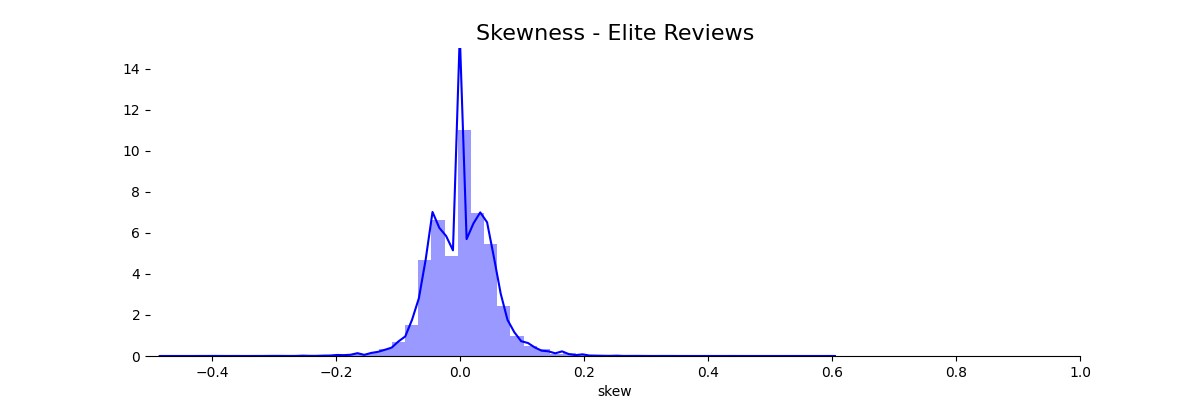

In [35]:
import seaborn as sns
plt.figure(figsize=(12,4))
sns.distplot(elite_skew["skew"], color="b")
sns.despine(left = True)
plt.title('Skewness - Elite Reviews', size = 16)
plt.axis((-0.5, 1, 0, 15))
%matplot plt

In [36]:
# Calculate skewness
a1 = elite_skew['skew'].median() #median
b1 = elite_skew['skew'].mean() #mean
c1 = elite_skew['skew'].std() #standard deviation
d1 = (3 * (b1-a1) / c1) #skewness

print('MEDIAN:', a1)
print('MEAM:', b1)
print('STD_DEV:', c1)
print('SKEWNESS:', d1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

MEDIAN: 0.0
MEAM: 0.001431251903984788
STD_DEV: 0.05049653244956872
SKEWNESS: 0.0850307041625595

Implications: 
According to the formula, I got skewness of 0.08503070416255945. 
Thus, Yelp reviews is positive It means reviewers who left a written response were more satisfied than normal.